<a href="https://colab.research.google.com/github/he16946/Data_Labs/blob/master/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Data

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

## Downloading data

In [2]:
os.environ['KAGGLE_USERNAME'] = "ce889group3" # username from the json file

os.environ['KAGGLE_KEY'] = "f0ec34f29bf37cceb765b25f5a1bce2c" # key from the json file

!kaggle datasets download -d geomack/spotifyclassification

  0% 0.00/98.4k [00:00<?, ?B/s]
100% 98.4k/98.4k [00:00<00:00, 28.6MB/s]


In [0]:
! unzip -q "spotifyclassification.zip"

In [0]:
df = pd.read_csv("data.csv")

In [5]:
df.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

In [6]:
print("Total count: ", df['target'].count())

Total count:  2017


In [7]:
print("Liked: ", df['target'].value_counts()[1])
print("Disliked: ", df['target'].value_counts()[0])

Liked:  1020
Disliked:  997


In [8]:
print('Like', round(df['target'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Dislike', round(df['target'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Like 50.57 % of the dataset
Dislike 49.43 % of the dataset


## Creating the imbalance

To create the ratio 60 : 40 we reduce the number of disliked songs to 612. 

First the two categories are split:

In [0]:
like = df.loc[df['target'] == 1]
dislike = df.loc[df['target'] == 0]

612 random rows are obtained from the Dislikes

In [0]:
newdis = dislike.sample(n = 612, random_state = 1)

In [0]:
imb = [like, newdis]
imb = pd.concat(imb)

In [12]:
print('Like', round(imb['target'].value_counts()[1]/len(imb) * 100,2), '% of the dataset')
print('Dislike', round(imb['target'].value_counts()[0]/len(imb) * 100,2), '% of the dataset')

Like 62.5 % of the dataset
Dislike 37.5 % of the dataset


## Preprocessing

In [13]:
imb.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


Song title and Artist name columns are removed

In [0]:
imb = imb.drop(['song_title', 'artist'], axis = 1)

In [15]:
norm = ((imb - imb.min())/(imb.max()-imb.min()))
norm.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target'],
      dtype='object')

## Cross-validation

In [16]:
features = list(norm.columns[1:14])
print(features)

['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


In [0]:
x = norm[features]
y = norm['target']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [37]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(x_train, y_train)
dummy.score(x_test, y_test)  

0.4877450980392157

In [62]:
dt = DecisionTreeClassifier(min_samples_split = 30, max_depth = 4, random_state = 32)
dt.fit(x_train, y_train)
print("DT score: ", dt.score(x_test, y_test))
print("Train score: ", cross_validate(dt, x_train, y_train)['test_score'].mean())
print("Test score: ", cross_validate(dt, x_test, y_test)['test_score'].mean())

DT score:  0.75
Train score:  0.7034058213449315
Test score:  0.7182174043962661


In [61]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf.fit(x_train, y_train)
print("RF score: ", rf.score(x_test, y_test))
print("Train score: ", cross_validate(rf, x_train, y_train)['test_score'].mean())
print("Test score: ", cross_validate(rf, x_test, y_test)['test_score'].mean())

RF score:  0.7524509803921569
Train score:  0.7483840749414521
Test score:  0.7255645889792232
Result:  0.7483840749414521


Feature ranking:
1. instrumentalness (0.278054)
2. energy (0.201206)
3. speechiness (0.183336)
4. loudness (0.102081)
5. valence (0.084643)
6. danceability (0.082695)
7. duration_ms (0.037390)
8. acousticness (0.023503)
9. tempo (0.007093)
10. time_signature (0.000000)
11. mode (0.000000)
12. liveness (0.000000)
13. key (0.000000)


(0.0, 0.29195660940196094)

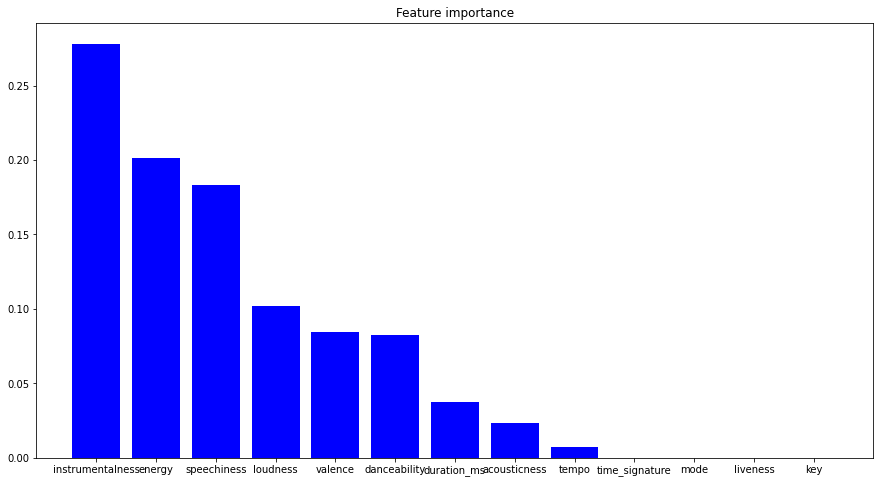

In [64]:
dt.fit(x, y)
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]])) 

fig = plt.figure()
plt.title("Feature importance")
plt.bar(range(x.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])

Feature ranking:
1. instrumentalness (0.240924)
2. energy (0.137020)
3. loudness (0.136484)
4. speechiness (0.112604)
5. acousticness (0.093243)
6. danceability (0.092033)
7. duration_ms (0.083251)
8. valence (0.047458)
9. tempo (0.022833)
10. liveness (0.019831)
11. key (0.007688)
12. mode (0.004906)
13. time_signature (0.001724)


(0.0, 0.3964670534309822)

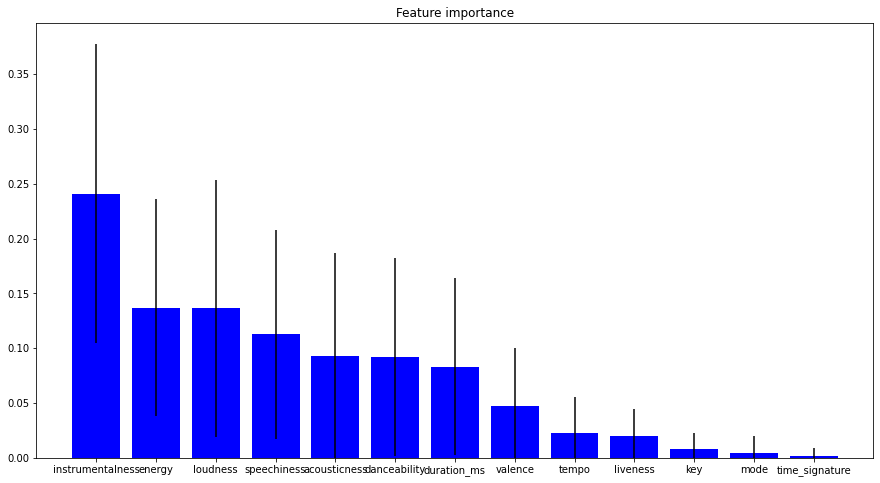

In [68]:
rf.fit(x, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

fig = plt.figure()
plt.title("Feature importance")
plt.bar(range(x.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])